参考文献
- [複数時系列データ × Transformerの実装と評価](https://zenn.dev/shungo_a/articles/1ae7e8c68b1cbb)

# 実験条件
- データは政府統計ポータブルサイトであるe-Statと統計ダッシュボードのデータを使用。具体的には、[機械受注統計調査](https://www.e-stat.go.jp/stat-search/files?page=1&query=%E6%A9%9F%E6%A2%B0%E5%8F%97%E6%B3%A8%E9%A1%8D%20%E9%95%B7%E6%9C%9F%E7%B3%BB%E5%88%97&layout=dataset&stat_infid=000009993379)、および、[日経平均株価](https://dashboard.e-stat.go.jp/timeSeriesResult?indicatorCode=0702020501000010010)のデータを使用。（今回は定常性の性質を持たせる、対数変換や階差などによる加工を実施。）
- 学習条件と予測データの条件配下に記載  
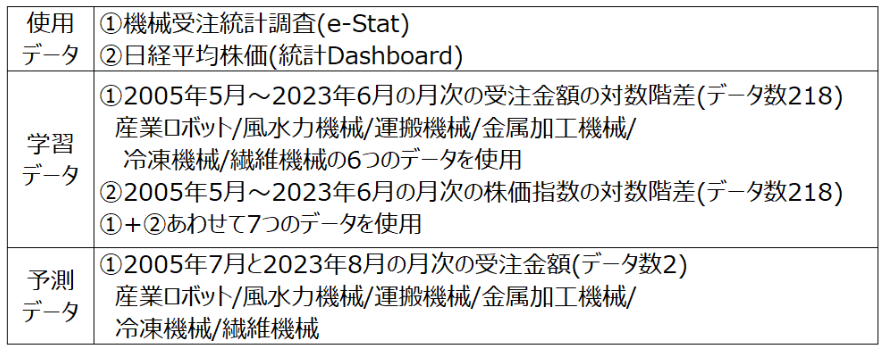


# Import

In [1]:
import pandas as pd
import numpy as np
import time
import sys

from iTransformer import iTransformer
import torch
import optuna

sys.path.append('../tools')
import dataset

# Dataset

## Check

In [2]:
#機械受注長期時系列

machinary_order_data = r'../data/FEH_00100401_240415220642.csv'
df_machinary_order_data = pd.read_csv(machinary_order_data, skiprows = 9, encoding='shift-jis') #2005年4月～2024年2月
df_machinary_order_data = df_machinary_order_data.sort_values('時間軸(月次) コード')

# numeric列は'xx,xxx'などのstr型格納されているのでfloat処理
numeric_cols = df_machinary_order_data.columns[7:]
# すべての列に対してカンマを取り除き、float型に変換
for column in numeric_cols:
    df_machinary_order_data[column] = df_machinary_order_data[column].str.replace(',', '').astype(float)

# 産業用ロボットを対数化
df_machinary_order_data["産業用ロボット対数化"] = np.log10(df_machinary_order_data["産業機械_産業用ロボット"]).diff()

In [3]:
df_machinary_order_data.head(1)

,表章項目 コード,表章項目,系列 コード,系列,時間軸(月次) コード,時間軸(月次),/機種分類(大中分類),合計（鉄構物、軸受、電線・ケーブルを除く）,原動機,原動機_原子力原動機,...,産業機械_その他,工作機械,鉄道車両,道路車両,航空機,船舶,鉄構物,軸受,電線・ケーブル,産業用ロボット対数化
226,100,金額【100万円】,110,原系列,2005000404,2005年4月,NaN,1988521.0,131044.0,30031.0,...,76800.0,99044.0,20845.0,51107.0,34280.0,214892.0,21407.0,50905.0,81030.0,NaN


In [4]:
#日経平均株価

stock_data = r'../data/TimeSeriesResult_20240415215057946.csv'
df_stock = pd.read_csv(stock_data)[63:-1] #2005年4月～2024年2月

In [5]:
df_stock.head(1)

,時点,地域コード,地域,日経平均株価【円】,注記
63,2005年4月,0,全国,11008.9,NaN


## Preprocessiong

### データの前処理

In [6]:
target_cols = [
    'Industrial_robots', 
    'Pneumatic_and_hydraulic_equipment',
    'materialshandling_machinery',
    'Metal_working_machinery',
    'Refrigerating_machines',
    'Plastics_pocessing_machinery',
    'stock'
]

crate_df = dataset.CreateTimeSeriesData(target_cols)
crate_df.create_base_df() #ベースマートの作成実行

df_original = crate_df.create_original_df_pipeline()
df_log = crate_df.create_log_df_pipeline()
month_lists = crate_df.month_lists
months = crate_df.months

In [7]:
# 対数化&階差処理
df_original

,2005年5月,2005年6月,2005年7月,2005年8月,2005年9月,2005年10月,2005年11月,2005年12月,2006年1月,2006年2月,...,2023年5月,2023年6月,2023年7月,2023年8月,2023年9月,2023年10月,2023年11月,2023年12月,2024年1月,2024年2月
Industrial_robots,-0.053338,0.061319,-0.081040,-0.056338,0.065137,-0.002607,-0.015000,0.016621,0.031647,0.001589,...,-0.082794,0.004572,-0.043979,-0.005308,-0.025318,0.024618,-0.090287,0.039461,-0.013098,0.059241
Pneumatic_and_hydraulic_equipment,-0.048584,0.157951,-0.067241,0.082728,0.088137,-0.076894,-0.017043,0.028569,-0.099801,0.003791,...,-0.036944,0.119198,-0.094939,0.076441,0.003425,-0.043711,0.025297,0.008926,-0.046609,-0.006342
materialshandling_machinery,0.007420,-0.054817,-0.056178,-0.011114,0.169994,-0.143864,-0.038000,0.022247,-0.036439,0.000716,...,-0.078413,0.091633,-0.059600,-0.028718,0.124432,0.017543,-0.221564,0.197849,-0.174590,0.123841
Metal_working_machinery,-0.000149,-0.077307,-0.008904,-0.044626,0.181167,-0.163452,0.056167,0.099571,-0.238417,0.022759,...,0.085240,0.029236,-0.027416,-0.007257,0.227005,-0.312200,0.061560,-0.065489,-0.079814,0.079749
Refrigerating_machines,0.076534,0.079561,-0.022921,-0.111261,0.071215,-0.150457,0.066918,0.026256,0.030871,-0.042184,...,0.059680,0.100122,-0.036733,-0.076222,0.040349,-0.080074,0.045630,0.049054,-0.167742,0.079437
Plastics_pocessing_machinery,-0.059261,0.023792,0.015508,0.048291,-0.021490,-0.025869,0.022084,0.034647,-0.003986,0.001527,...,-0.008490,0.013389,-0.043603,-0.051092,0.184180,-0.249189,-0.066775,0.195613,0.077195,-0.151136
stock,0.010434,0.011681,0.011673,0.018365,0.038820,0.001029,0.038627,0.034760,0.014275,-0.011749,...,0.029545,0.031207,-0.000220,-0.007299,-0.010262,-0.013834,0.035495,-0.000295,0.035168,0.033164


In [8]:
# 対数化のみ
df_log

,2005年5月,2005年6月,2005年7月,2005年8月,2005年9月,2005年10月,2005年11月,2005年12月,2006年1月,2006年2月,...,2023年5月,2023年6月,2023年7月,2023年8月,2023年9月,2023年10月,2023年11月,2023年12月,2024年1月,2024年2月
Industrial_robots,4.574355,4.635675,4.554635,4.498297,4.563434,4.560827,4.545826,4.562448,4.594094,4.595684,...,4.688918,4.693490,4.649510,4.644202,4.618884,4.643502,4.553215,4.592676,4.579578,4.638819
Pneumatic_and_hydraulic_equipment,4.661415,4.819366,4.752125,4.834853,4.922990,4.846096,4.829053,4.857622,4.757821,4.761612,...,4.931193,5.050391,4.955452,5.031893,5.035318,4.991607,5.016904,5.025830,4.979220,4.972878
materialshandling_machinery,4.967815,4.912997,4.856819,4.845706,5.015699,4.871836,4.833835,4.856082,4.819643,4.820359,...,4.944848,5.036481,4.976882,4.948163,5.072595,5.090138,4.868574,5.066423,4.891833,5.015674
Metal_working_machinery,4.463699,4.386392,4.377488,4.332862,4.514029,4.350577,4.406745,4.506316,4.267899,4.290658,...,4.393698,4.422934,4.395519,4.388261,4.615266,4.303066,4.364626,4.299137,4.219323,4.299071
Refrigerating_machines,4.553786,4.633347,4.610426,4.499165,4.570379,4.419923,4.486841,4.513098,4.543969,4.501785,...,4.641345,4.741467,4.704734,4.628512,4.668861,4.588787,4.634417,4.683470,4.515728,4.595165
Plastics_pocessing_machinery,4.241073,4.264865,4.280373,4.328665,4.307175,4.281306,4.303390,4.338038,4.334051,4.335578,...,4.413886,4.427275,4.383672,4.332580,4.516760,4.267571,4.200796,4.396409,4.473604,4.322467
stock,4.052178,4.063859,4.075532,4.093898,4.132717,4.133746,4.172374,4.207134,4.221410,4.209661,...,4.489788,4.520995,4.520775,4.513475,4.503213,4.489380,4.524875,4.524580,4.559748,4.592911


### モデル用マート作成
- パラメータ探索用のデータ`train_data`と予測用のデータ`pred_train_data`を作成
- 期間を6分割してbatchを定義。batchの区切り方については`iTransformer_データの区切り方.xlsx`をご参照
- iTransformerモデルへのインプットデータは`(batch, lockback len, varites)`のテンソルを要求  
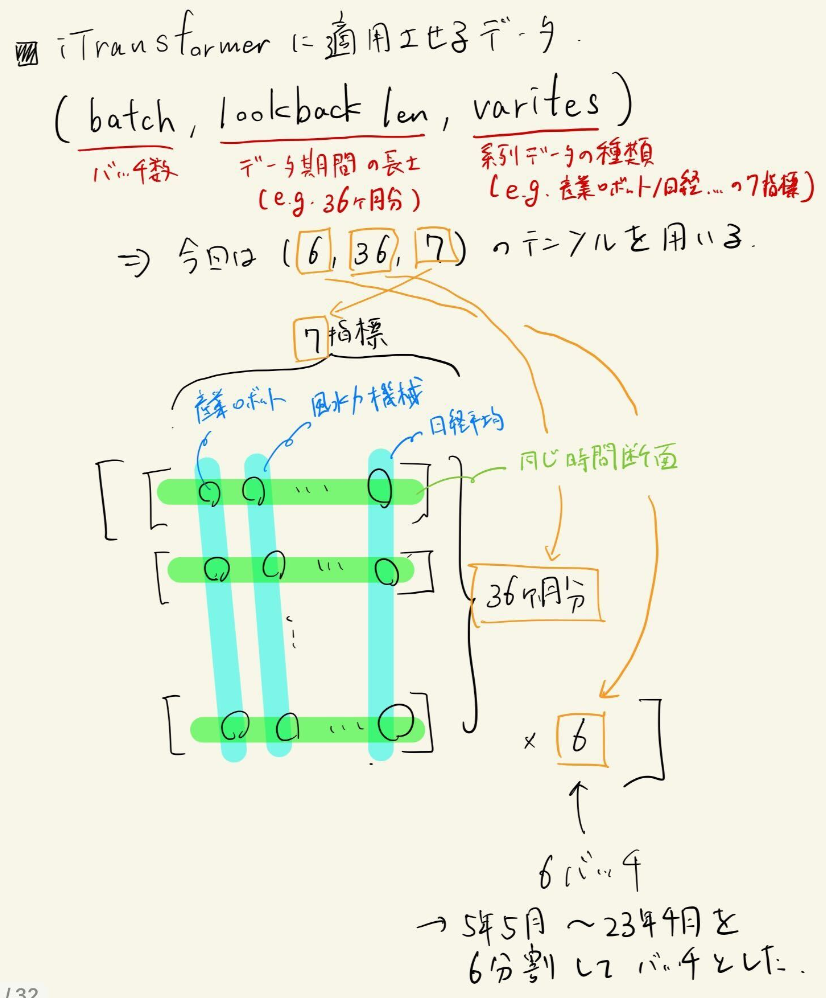

In [9]:
#iTransformer用のテンソル配列作成関数
def Make_iTransformer_data(df_csv,time_name,start_index,end_index,df_use) :
  #df_use : 時系列データをまとめる際に使用するデータフレーム
  #df_csv : 時刻をカラムに持つcsvのデータフレーム
  #start_index,end_index : 月のカラムの始まりと終わりのインデックス
  #time_name : 時刻カラム名(本記事では「時点」)
  #month : 取得月リスト
  months = list(df_csv[time_name][start_index:end_index])

  #iTransformerでは、3次元目の過去データ用のデータテンソル作成
  #(batch,lookbacknum,variates)
  #したがって、tensor.Size([1,lookbunnum,variates])のテンソル配列を作成
  #まず、tensor.Size([lookbunnum,variates])作成のための配列(np_target)を作成
  df_target = df_use[months].T
  np_target = df_target.to_numpy()

  #時系列データとして、tensor.Size([1,lookbunnum,variates])を作成
  #バッチをrepeatを用いて作成
  timeseries_data = torch.tensor(np_target)
  timeseries_data = timeseries_data.repeat(1, 1, 1)
  reslut_data = timeseries_data.to(torch.float32)

  # CPUまたはGPU上にテンソルを配置
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  reslut_data = reslut_data.to(device)

  return reslut_data

In [10]:
#訓練データ size (6,36,7)
train1_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",1,37,df_original)
train2_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",37,73,df_original)
train3_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",73,109,df_original)
train4_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",109,145,df_original)
train5_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",145,181,df_original)
train6_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",181,217,df_original)
# テンソルを結合して新しい形状を持つテンソルを作成
train_data = torch.cat((train1_data, train2_data,train3_data,
                        train4_data,train5_data,train6_data), dim=0)

print(train_data.shape)

torch.Size([6, 36, 7])


In [11]:
#予測時使用データ
train1_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",3,39,df_original)
train2_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",39,75,df_original)
train3_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",75,111,df_original)
train4_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",111,147,df_original)
train5_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",147,183,df_original)
train6_data = Make_iTransformer_data(df_machinary_order_data,"時間軸(月次)",183,219,df_original)
# テンソルを結合して新しい形状を持つテンソルを作成
pred_train_data = torch.cat((train1_data, train2_data,train3_data,train4_data,train5_data,train6_data), dim=0)

print(pred_train_data.shape)

torch.Size([6, 36, 7])


# Predict

In [12]:
# using solar energy settings

model = iTransformer(
    num_variates = 137,                 # 時系列データ数
    lookback_len = 96,                  # 時系列データの長さ
    dim = 256,                          # 埋め込みベクトルの次元数
    depth = 6,                          # 層の深さ
    heads = 8,                          # self attentionのhead数
    dim_head = 64,                      # headの次元数
    pred_length = (12, 24, 36, 48),     # 予測期間の長さ
    num_tokens_per_variate = 1,         # 時系列データに対して特徴量を増加する際に使用する変数。埋め込みベクトル×num_tokens_per_variateに拡張
)

time_series = torch.randn(2, 96, 137)  # (バッチ,時系列のデータの長さ, 時系列データの長さ)

preds = model(time_series)

# preds -> Dict[int, Tensor[batch, pred_length, variate]]
#       -> (12: (2, 12, 137), 24: (2, 24, 137), 36: (2, 36, 137), 48: (2, 48, 137))

## パラメータ探索

In [13]:
#予測の階差を用いた実際の対数値のフレームの更新
def Make_dfdiff_reverse(df_ori,df_diff) :
  #結果データフレームの作成のための変数作成
  rows,columns = df_ori.shape
  df_result = df_ori.copy()

  for i in range(0,rows) :
    #前月の対数値の保存
    before_term = df_ori.iloc[i,0]
    for j in range(1,columns) :
      #前月の対数値に予測の階差値を加算して予測の対数値を作成
      df_result.iloc[i,j] = before_term + df_diff.iloc[i,j-1]
      #前月の対数値の更新
      before_term = df_result.iloc[i,j]

  return df_result

In [14]:
#パラメータ探索関数
def iTransformer_params(train,df_ori,valid_terms) :
    
    def objective(trial) :
        #パラメータ設定
        params = {
            'num_variates' : 7,
            'lookback_len' : 36,
            'dim' :  trial.suggest_int('dim',250,350), #モデル内で使用される各トークンの埋め込みベクトルのサイズや、内部で処理される特徴量の次元数
            'depth' : trial.suggest_int('depth',1,20), #モデルの深さ、つまりTransformerブロックの数
            'heads' : trial.suggest_int('heads',1,20), #マルチヘッドアテンション機構で使用される「ヘッド」の数
            'dim_head' : trial.suggest_int('dim_head',8,32), #各アテンションヘッドの次元数
            'pred_length' : 2,
            'num_tokens_per_variate' : trial.suggest_int('num_tokens_per_variate',2,25) #各変数の時系列データをどれだけのトークン（部分列）に分割するかを示す
            #'num_tokens_per_variate' : 1
        }

        #パラメータ適用モデル
        itrans_model = iTransformer(
            num_variates = params['num_variates'],
            lookback_len = params['lookback_len'],
            dim = params['dim'],
            depth = params['depth'],
            heads = params['heads'],
            dim_head = params['dim_head'],
            pred_length = params['pred_length'],
            num_tokens_per_variate = params['num_tokens_per_variate']
        )

        #モデル予測
        itrans_preds = itrans_model(train)
        #結果の予測配列をテンソル型にする
        for key,value in itrans_preds.items() :
            pred_tensor = torch.tensor(value)
        pred_MAEtensor = pred_tensor.transpose(1, 2)
        #batch_count : バッチ数, graph_count : 時系列のデータ数, pred_step_count : 予測期間の長さ
        batch_count,graph_count,pred_step_count = pred_MAEtensor.shape

        #予測期間と実際の値の誤差
        index_lists = df_ori.index
        month_lists = df_ori.columns
        sumABS = 0.0

        for b in range(0,batch_count) :
          pred_arr = pred_MAEtensor[b].numpy() #予測値(階差)のデータ格納
          #df_result : 予測値を格納するデータフレーム
          start_months_index, end_months_index= valid_terms[b]
          result_months = month_lists[start_months_index+1:end_months_index]
          df_result = pd.DataFrame(data=pred_arr, index=index_lists,columns=result_months)
          #検証とテストのデータフレームを格納
          #df_valid : 実際の対数変換のデータフレーム
          #df_test : 階差の予測値を使用し、
          #          Make_dfdiff_reverse関数で算出した対数変換のテスト用データフレーム
          valid_months = month_lists[start_months_index:end_months_index]
          df_valid = df_ori[valid_months]
          df_test = Make_dfdiff_reverse(df_valid,df_result)

          for g in range(0,graph_count) :
            for ps in range(0,pred_step_count) :
              #実際の対数値と予測の対数値の誤差の計算
              sumABS += np.abs(df_valid.iloc[g,ps+1] - df_test.iloc[g,ps])

        return sumABS / (batch_count * graph_count * pred_step_count)

    return objective


In [15]:
#パラメータの最適値探索
def optuna_parameter(train,df_ori,valid_terms) :
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42))
    #探索回数 1800回 or 探索時間610秒に達するいずれかを満たせば、1回の探索終了
    study.optimize(iTransformer_params(train,df_ori,valid_terms), n_trials=1800,timeout=610)
    optuna_best_params = study.best_params

    return study

In [16]:
valid_terms = [
    [36,39],    #2008年4月～6月
    [72,75],    #2011年4月～6月
    [108,111],  #2014年4月～7月
    [144,147],  #2017年4月～6月
    [180,183],  #2020年4月～6月
    [216,219]   #2023年4月～6月
]

In [17]:
optuna_count = 9 # 回数制限も書いておきました。別途調整してください。
best_values = 99999999
#best_params = ""
start_time = time.time()
for i in range(0,optuna_count):
  study = optuna_parameter(train_data,df_log,valid_terms)
  now_deal_time = time.time() - start_time
  if study.best_value < best_values :
    best_params = study.best_params
    best_values = study.best_value
  print("--------------------------------")
  print("optimize count", str(i + 1))
  print("best_params : ",best_params)
  print("best_values : ", best_values)
  print("--------------------------------")

  if 2400 <= now_deal_time :
    print("--------------------------------")
    print("optimize count", str(i + 1))
    print("best_params : ",best_params)
    print("best_values : ", best_values)
    print("--------------------------------")
    break


[I 2024-04-20 00:06:23,068] A new study created in memory with name: no-name-a37d6a8c-dea8-4966-aaeb-b99f3220aaa5
C:\Users\takuya.tokumoto\AppData\Local\Temp\ipykernel_3716\655602346.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_tensor = torch.tensor(value)
[I 2024-04-20 00:06:26,440] Trial 0 finished with value: 0.48679624235869945 and parameters: {'dim': 287, 'depth': 20, 'heads': 15, 'dim_head': 22, 'num_tokens_per_variate': 5}. Best is trial 0 with value: 0.48679624235869945.
[I 2024-04-20 00:06:27,089] Trial 1 finished with value: 0.22370935257756172 and parameters: {'dim': 265, 'depth': 2, 'heads': 18, 'dim_head': 23, 'num_tokens_per_variate': 18}. Best is trial 1 with value: 0.22370935257756172.
[I 2024-04-20 00:06:28,662] Trial 2 finished with value: 0.16336371542444278 and parameters: {'dim': 252, 'depth': 20, 'head

[I 2024-04-20 00:06:32,422] Trial 7 finished with value: 0.11373600949863048 and parameters: {'dim': 331, 'depth': 7, 'heads': 2, 'dim_head': 25, 'num_tokens_per_variate': 12}. Best is trial 7 with value: 0.11373600949863048.
[I 2024-04-20 00:06:32,806] Trial 8 finished with value: 0.5686214073346203 and parameters: {'dim': 262, 'depth': 10, 'heads': 1, 'dim_head': 30, 'num_tokens_per_variate': 8}. Best is trial 7 with value: 0.11373600949863048.
[I 2024-04-20 00:06:33,470] Trial 9 finished with value: 0.20645140228541936 and parameters: {'dim': 316, 'depth': 7, 'heads': 11, 'dim_head': 21, 'num_tokens_per_variate': 6}. Best is trial 7 with value: 0.11373600949863048.
[I 2024-04-20 00:06:35,651] Trial 10 finished with value: 0.1470695594583666 and parameters: {'dim': 347, 'depth': 16, 'heads': 19, 'dim_head': 30, 'num_tokens_per_variate': 16}. Best is trial 7 with value: 0.11373600949863048.
[I 2024-04-20 00:06:35,804] Trial 11 finished with value: 0.27592967845220173 and parameters: {

--------------------------------
optimize count 1
best_params :  {'dim': 309, 'depth': 2, 'heads': 13, 'dim_head': 32, 'num_tokens_per_variate': 6}
best_values :  0.09904469159378533
--------------------------------


[I 2024-04-20 00:16:34,420] Trial 0 finished with value: 0.1443618840778484 and parameters: {'dim': 287, 'depth': 20, 'heads': 15, 'dim_head': 22, 'num_tokens_per_variate': 5}. Best is trial 0 with value: 0.1443618840778484.
[I 2024-04-20 00:16:34,597] Trial 1 finished with value: 0.14928570777907968 and parameters: {'dim': 265, 'depth': 2, 'heads': 18, 'dim_head': 23, 'num_tokens_per_variate': 18}. Best is trial 0 with value: 0.1443618840778484.
[I 2024-04-20 00:16:35,123] Trial 2 finished with value: 0.3330934571420728 and parameters: {'dim': 252, 'depth': 20, 'heads': 17, 'dim_head': 13, 'num_tokens_per_variate': 6}. Best is trial 0 with value: 0.1443618840778484.
[I 2024-04-20 00:16:35,390] Trial 3 finished with value: 0.1530053485920868 and parameters: {'dim': 268, 'depth': 7, 'heads': 11, 'dim_head': 18, 'num_tokens_per_variate': 8}. Best is trial 0 with value: 0.1443618840778484.
[I 2024-04-20 00:16:35,573] Trial 4 finished with value: 0.26923095280791237 and parameters: {'dim':

## 予測結果出力

In [ ]:
#モデル実装
itrans_model = iTransformer(
    num_variates = 7,
    lookback_len = 36,
    dim = best_params['dim'],
    depth = best_params['depth'],
    heads = best_params['heads'],
    dim_head = best_params['dim_head'],
    num_tokens_per_variate = best_params['num_tokens_per_variate'],
    pred_length = 2
    )
#モデル適用
itrans_preds = itrans_model(pred_train_data)
#予測値格納
for key,value in itrans_preds.items() :
  pred_MAEtensor = torch.tensor(value)

C:\Users\takuya.tokumoto\AppData\Local\Temp\ipykernel_4504\622640202.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_MAEtensor = torch.tensor(value)


# Evaluate

- 学習と出力値が階差の値を取っていることに注意

In [ ]:
pred_valid_terms = [
    [38,41],    #2008年6月～8月
    [74,77],    #2011年6月～8月
    [110,113],  #2014年6月～8月
    [146,149],  #2017年6月～8月
    [182,185],  #2020年6月～8月
    [218,221]   #2023年6月～8月
]

In [ ]:
start_months_index, end_months_index= pred_valid_terms[0]
month_lists[start_months_index+1:end_months_index]

['2008年7月', '2008年8月']

In [ ]:
batch_count,_,_ = pred_MAEtensor.shape

#予測期間と実際の値の誤差
index_lists = df_log.index
# month_lists = df_log.columns

for b in range(0,batch_count) :
    pred_arr = pred_MAEtensor[b].numpy() #予測値(階差)のデータ格納
    #df_result : 予測値を格納するデータフレーム
    start_months_index, end_months_index= pred_valid_terms[b]
    result_months = month_lists[start_months_index+1:end_months_index]
    df_result = pd.DataFrame(data=pred_arr.T, index=index_lists,columns=result_months)
    #検証とテストのデータフレームを格納
    #df_valid : 実際の対数変換のデータフレーム
    #df_test : 階差の予測値を使用し、
    #          Make_dfdiff_reverse関数で算出した対数変換のテスト用データフレーム
    valid_months = month_lists[start_months_index:end_months_index]
    df_valid = df_log[valid_months]
    df_test = Make_dfdiff_reverse(df_valid,df_result)

In [ ]:
# 正解データ
df_log[valid_months]

,2023年6月,2023年7月,2023年8月
Industrial_robots,4.693490,4.649510,4.644202
Pneumatic_and_hydraulic_equipment,5.050391,4.955452,5.031893
materialshandling_machinery,5.036481,4.976882,4.948163
Metal_working_machinery,4.422934,4.395519,4.388261
Refrigerating_machines,4.741467,4.704734,4.628512
Plastics_pocessing_machinery,4.427275,4.383672,4.332580
stock,4.520995,4.520775,4.513475


In [ ]:
# 予測値(23年6月の正解データから予測の階差値を使って7・8月算出)
df_test

,2023年6月,2023年7月,2023年8月
Industrial_robots,4.693490,3.954701,4.390390
Pneumatic_and_hydraulic_equipment,5.050391,4.369549,5.134614
materialshandling_machinery,5.036481,4.274904,5.005897
Metal_working_machinery,4.422934,4.085288,4.497529
Refrigerating_machines,4.741467,4.182563,4.708766
Plastics_pocessing_machinery,4.427275,3.873338,4.587717
stock,4.520995,3.750571,4.503102


In [ ]:
# 予測値 - 正解データ
df_test - df_log[valid_months]

,2023年6月,2023年7月,2023年8月
Industrial_robots,0.0,-0.694809,-0.253812
Pneumatic_and_hydraulic_equipment,0.0,-0.585903,0.102721
materialshandling_machinery,0.0,-0.701978,0.057733
Metal_working_machinery,0.0,-0.310231,0.109268
Refrigerating_machines,0.0,-0.522170,0.080255
Plastics_pocessing_machinery,0.0,-0.510334,0.255137
stock,0.0,-0.770204,-0.010374
